In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%matplotlib inline

Based on https://blog.evjang.com/2018/12/uncertainty.html

When using ensemble models, we can generate distribution of predicted labels
for a given sample (each model in the ensemble is different and can output different label).

The idea is that the label distribution will have larger spread* for out-of-distribution samples (samples
that come from diferent distribution than the training set). For classification tasks, we can measure this
spread using entropy (variance for regression tasks).

\* spread = dispersion (https://en.wikipedia.org/wiki/Statistical_dispersion)

In [67]:
# https://en.wikipedia.org/wiki/Entropy_(information_theory)
def categorical_entropy(y):
    p_y = (pd.Series(y).value_counts() / len(y)).values
    return -np.sum(p_y * np.log2(p_y)) 


def test_categorical_entropy():
    y = ['Moscow', 'Moscow', 'Paris', 'London', 'London', 
         'London', 'NYC', 'NYC', 'NYC', 'NYC']
    
    assert categorical_entropy(y) == 1.8464393446710154


test_categorical_entropy()

In [68]:
np.random.seed(0)


def generate_data(n_samples):
    return make_classification(n_samples=n_samples, n_classes=8, n_informative=10, n_repeated=0)


X, y = generate_data(5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_ood, _ = generate_data(X_test.shape[0])
X_ood += X.max() * 10

In [117]:
def sample_dataset_with_replacement(X, y):
    
    n = X.shape[0]
    idx = np.random.randint(0, n, size=n)
    return X[idx, :], y[idx]


def test_sample_dataset_with_replacement():
    n = 10000
    X = np.array(range(n))[:, np.newaxis]
    y = np.array(range(n))
    
    X_, _ = sample_dataset_with_replacement(X, y)
    share = np.unique(X_).shape[0] / n
    assert round(share * 10) == 6


test_sample_dataset_with_replacement()
    

def create_bagging(X, y, m=50):
    return [sample_dataset_with_replacement(X, y) for _ in range(m)]


def lr_factory():
    return LogisticRegression()


def fit_bagging(X, y, m=50, model_factory=lr_factory):

    bagging = create_bagging(X, y, m)   
    return [model_factory().fit(X, y) for X, y in bagging]


def predict_bagging(X, models):
    return np.hstack([m.predict(X)[:, np.newaxis] for m in models])

In [102]:
models = fit_bagging(X, y, m=50)

In [118]:
y_pred = predict_bagging(X_test, models)
y_ood_pred = predict_bagging(X_ood, models)

In [128]:
# 50 labels for each of the 1250 samples
y_pred.shape

(1250, 50)

In [124]:
y_pred_entropy = np.apply_along_axis(categorical_entropy, 1, y_pred)
y_ood_pred_entropy = np.apply_along_axis(categorical_entropy, 1, y_ood_pred)

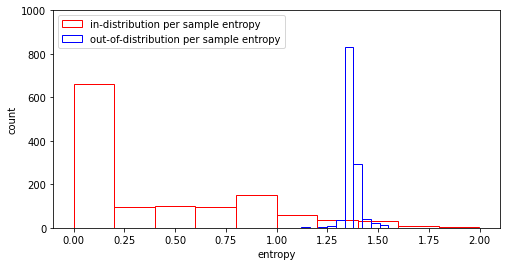

In [126]:
plt.subplots(1, 1, figsize=(8, 4))
plt.hist(y_pred_entropy, label='in-distribution per sample entropy',
         edgecolor='red', linewidth=1, fill=None)

plt.hist(y_ood_pred_entropy, label='out-of-distribution per sample entropy',
         edgecolor='blue', linewidth=1, fill=None)

plt.xlabel('entropy')
plt.ylabel('count')
plt.ylim([0, 1000])
plt.legend()
plt.show()